In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU
from tensorflow import keras

In [3]:
dataset = keras.utils.image_dataset_from_directory(
    'faces/',
    color_mode='rgb',
    batch_size=100,
    image_size=(20, 20),
    shuffle=True,
)

Found 3472 files belonging to 1 classes.


In [4]:
images_list = []

for images, labels in dataset:
    images_list.append(images)

images = np.concatenate(images_list, axis=0)


In [ ]:
plt.imshow(images[18])

In [5]:
BUFFER_SIZE = images.shape[0]
BATCH_SIZE = 100

In [6]:
BUFFER_SIZE = BUFFER_SIZE // BATCH_SIZE * BATCH_SIZE
images = images[:BUFFER_SIZE]

In [7]:
images.shape

(3400, 20, 20, 3)

In [8]:
images = images / 255

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [10]:
hidden_dim = 4

In [24]:
generator = tf.keras.Sequential([
    
    Dense(5 * 5 * 64, activation='relu'), #5х5
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.3),
    # Dense(5 * 5 * 256, activation='relu'),
    # BatchNormalization(),
    # LeakyReLU(),
    
  Reshape((5, 5, 64)),
    
  Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', activation='relu'),
  BatchNormalization(),
  LeakyReLU(),
  Dropout(0.3),

  Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', activation='relu'),
])

In [25]:
discriminator = tf.keras.Sequential([

Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[20, 20, 3]),
LeakyReLU(),
Dropout(0.3),

Conv2D(32, (5, 5), strides=(2, 2), padding='same'),
LeakyReLU(),
Dropout(0.3),
    
Flatten(),
Dense(1)

])

In [26]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [27]:
def generator_loss(fake_output):
  loss = cross_entropy(tf.ones_like(fake_output), fake_output)
  return loss

In [28]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [29]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [30]:
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, hidden_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True) # generate img

    real_output = discriminator(images, training=True) # gradient of real in disc
    fake_output = discriminator(generated_images, training=True) # gradient of generated in disc

    gen_loss = generator_loss(fake_output) # loss of generation 
    disc_loss = discriminator_loss(real_output, fake_output) # loss of discriminator

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables) # calculate gradients 
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables) 

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables)) # apply optimizer 
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  return gen_loss, disc_loss

In [31]:
import time
def train(dataset, epochs):
  history = []
  MAX_PRINT_LABEL = 10
  th = BUFFER_SIZE / (BATCH_SIZE * MAX_PRINT_LABEL)

  for epoch in range(1, epochs + 1):
    print(f'{epoch}/{EPOCHS}: ', end='')

    start = time.time()
    n = 0

    gen_loss_epoch = 0
    for image_batch in dataset:
      gen_loss, disc_loss = train_step(image_batch)
      gen_loss_epoch += K.mean(gen_loss)
      if (n % th == 0): print('=', end='')
      n += 1

    history += [gen_loss_epoch / n]
    print(': ' + str(history[-1]))
    print('Время эпохи {} составляет {} секунд'.format(epoch, time.time() - start))

  return history

In [32]:
EPOCHS = 3000
history = train(train_dataset, EPOCHS)

1/3000: WARNING:tensorflow:From C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\normalization\batch_normalization.py:964: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

=: tf.Tensor(0.61453086, shape=(), dtype=float32)
Время эпохи 1 составляет 4.709980249404907 секунд
2/3000: =: tf.Tensor(0.67075574, shape=(), dtype=float32)
Время эпохи 2 составляет 1.4206805229187012 секунд
3/3000: =: tf.Tensor(0.9252267, shape=(), dtype=float32)
Время эпохи 3 составляет 1.6143074035644531 секунд
4/3000: =: tf.Tensor(1.2635578, shape=(), dtype=float32)
Время эпохи 4 составляет 1.449826955795288 секунд
5/3000: =: tf.Tensor(1.639868, shape=(), dtype=float32)
Время эпохи 5 составляет 1.4006969928741455 секунд
6/3000: =: tf.Tensor(2.0930767, shape=(), dtype=float32)
Время эпохи 6 составляет 1.3943877220153809 секунд
7/3000: =: tf.Tensor(2.4866133, shape=(), dtype=float32)
Время эпохи 7 составляет 1.422649621963501 секунд
8/3000: =: tf.Tenso

KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


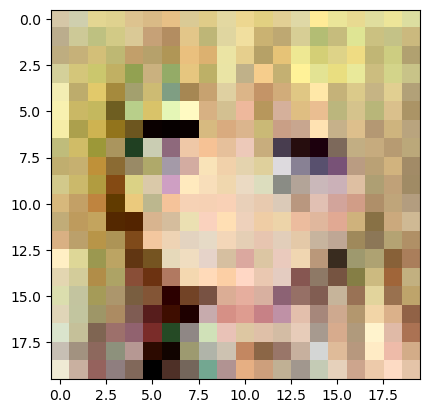

In [61]:
noise = tf.random.normal([BATCH_SIZE, hidden_dim])
generated_images = generator(noise)
plt.imshow(generated_images[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

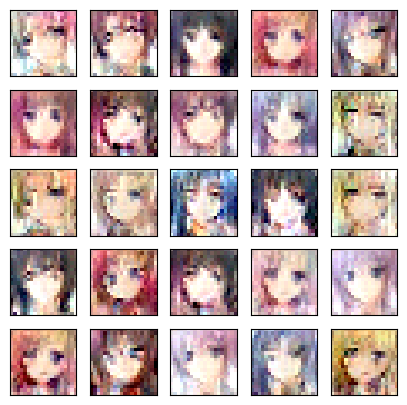

In [63]:
n = 2
total = 2 * n + 1
plt.figure(figsize=(5, 5))
num = 1
for i in range(25):
    noise = tf.random.normal([BATCH_SIZE, hidden_dim])
    ax = plt.subplot(total, total, num)
    num += 1
    img = generator(noise)
    plt.imshow(img[0])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [33]:
generator.save('20x20_anime_faces_gen_2000.keras')

In [34]:
discriminator.save('20x20_anime_faces_disc_2000.keras')